## Defining custom metric

In [4]:
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Preparing data to pass into the final functions

In [5]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns
import numpy as np
import re
import datetime as dt
from datetime import datetime
import mask_functions
import pydicom as dicom
from tqdm.notebook import tqdm
from glob import glob
import pandas as pd
import tensorflow_io as tfio
import tensorflow as tf
from keras.models import load_model
import time
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf


#reading all dcm files into train and text
train = sorted(glob("pneumothorax/dicom-images-train/*/*/*.dcm")) #There is an image after 2subfolders . Rather than manually typing the entire path we are using glob to access the image with ease
#reading the csv
dataset = pd.read_csv("pneumothorax/train-rle.csv", delimiter=",")

In [6]:
train_df=[]
remove=[]
for i in tqdm(train):
  sample=dicom.dcmread(i) #reading each image
  train={}
  train["UID"]=sample.SOPInstanceUID 
  
  try: #try and except to avoid throwing an error in case any file is missing
    encoded_pixels = dataset[dataset["ImageId"] == train["UID"]].values[0][1] #We are checking wheather each image(from the train) present has been mapped to the csv file given . 
    train["EncodedPixels"]=encoded_pixels
  except:
    remove.append("pneumothorax/dicom-images-train/" + sample.StudyInstanceUID + "/" + sample.SeriesInstanceUID + "/" + sample.SOPInstanceUID + ".dcm")#if the image details are not present in the csv that means that the file is missing
  train["path"] = "pneumothorax/dicom-images-train/" + sample.StudyInstanceUID + "/" + sample.SeriesInstanceUID + "/" + sample.SOPInstanceUID + ".dcm" #saving the path in csv for further reference
  train_df.append(train)
patients_train = pd.DataFrame(train_df,columns=["EncodedPixels","path"])

patients_train=patients_train.loc[~patients_train['path'].isin(remove)]

In [7]:
train_path=[]
train_encoded_pixel=[]
test_path=[]
test_encoded_pixel=[]
train_len=len(patients_train)-int(len(patients_train)*0.2)                          #We are dividing the data into train and test
test_len=int(len(patients_train)*0.2)
count=0

for i in tqdm(range(0,len(patients_train))):
  if count<=train_len:
    train_path.append(list(patients_train['path'].values)[i])
    train_encoded_pixel.append(list(patients_train['EncodedPixels'].values)[i])
    count=count+1
  else:
    test_path.append(list(patients_train['path'].values)[i])
    test_encoded_pixel.append(list(patients_train['EncodedPixels'].values)[i])


#Function -1

In [41]:
#Function-1
def final_fun_1(X):
  img = tf.io.read_file(X)
  image = tfio.image.decode_dicom_image(img, dtype=tf.uint8,color_dim=True,scale='preserve')
  image = tf.image.convert_image_dtype(image, tf.float32)#converting the image to tf.float32
  image=tf.squeeze(image,[0]) #squeezing the image because the file is of the shape(1,1024,1024,1) and we want (1024,1024,3)
  b = tf.constant([1,1,3], tf.int32)
  image=tf.tile(image,b)#the image is of the shape (1024,1024,1) to make it (1024,1024,3) I am using tf.tile
  image=tf.image.resize(image,size=[256,256])
  image=tf.expand_dims(image,axis=0)
   #recall
  if model.predict(image)>=0.5:
    print("Pneumothorax has been detected")
    mask=final.predict(image)
    mask=(mask>0.5).astype(np.uint8)
    plt.figure(figsize=(20,6))
    plt.title("Mask")
    
    return plt.imshow(np.squeeze(mask),cmap='gray')
  else:
    return "No Pneumothorax Detected"

#Function-2

In [25]:
#Function-2
def final_fun_2(X,Y):
  img = tf.io.read_file(X)
  image = tfio.image.decode_dicom_image(img, dtype=tf.uint8,color_dim=True,scale='preserve')
  image = tf.image.convert_image_dtype(image, tf.float32)#converting the image to tf.float32
  image=tf.squeeze(image,[0]) #squeezing the image because the file is of the shape(1,1024,1024,1) and we want (1024,1024,3)
  b = tf.constant([1,1,3], tf.int32)
  image=tf.tile(image,b)#the image is of the shape (1024,1024,1) to make it (1024,1024,3) I am using tf.tile
  image=tf.image.resize(image,size=[256,256])
  image=tf.expand_dims(image,axis=0)
  if Y!=" -1":
    print("Ground truth of Classification is 1(Has Pneumothorax)")
    print('*'*100)
  else:
    print("Ground truth of Classification is 0(Does not have Pneumothorax)")
    print("Ground truth of Segmentation -- There is no mask")
    print('*'*100)

  if model.predict(image)>=0.5:
    print("Pneumothorax has been detected")
    mask=final.predict(image)
    mask=(mask>0.5).astype(np.uint8)
    try:
      true_mask=Image.fromarray(mask_functions.rle2mask(Y,1024,1024).T).resize((256,256), resample=Image.BILINEAR) 
      true_mask=np.array(true_mask)
      plt.figure(figsize=(20,6))
      plt.subplot(121)
      plt.title("X-ray image with mask(Ground truth)")
      plt.imshow(np.squeeze(image),cmap='gray')
      plt.imshow(np.squeeze(true_mask),cmap='gray',alpha=0.3)
      plt.subplot(122)
      plt.title("X-ray image with mask(Predicted)")
      plt.imshow(np.squeeze(image),cmap='gray')
      plt.imshow(np.squeeze(mask),cmap='gray',alpha=0.3)
      return plt.show()
    except: #if there is no ground truth mask
      plt.figure(figsize=(20,6)) 
      plt.title("X-ray image with mask(Predicted)")
      plt.imshow(np.squeeze(image),cmap='gray')
      plt.imshow(np.squeeze(mask),cmap='gray',alpha=0.3)
      return plt.show()




#Final Predictions for function 1 and function 2 respectively

In [38]:
 #Selecting a random value from the test data
rand=random.randrange(0,len(test_path))
model=load_model('weights-30-0.9705.hdf5')
final=tf.keras.models.load_model('/content/drive/My Drive/model_save/weights-12-0.4656.hdf5', custom_objects={'dice_coef':dice_coef})

Pneumothorax has been detected
--- 0.21987628936767578 seconds ---


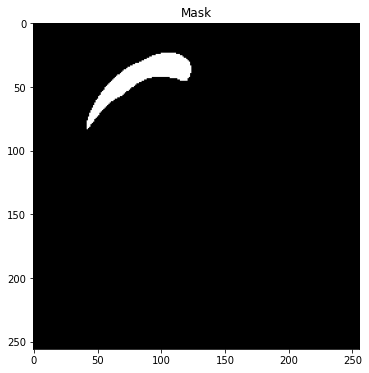

In [43]:
start_time = time.time()
final_fun_1(test_path[rand])
print("--- %s seconds ---" % (time.time() - start_time))

Ground truth of Classification is 1(Has Pneumothorax)
****************************************************************************************************
Pneumothorax has been detected


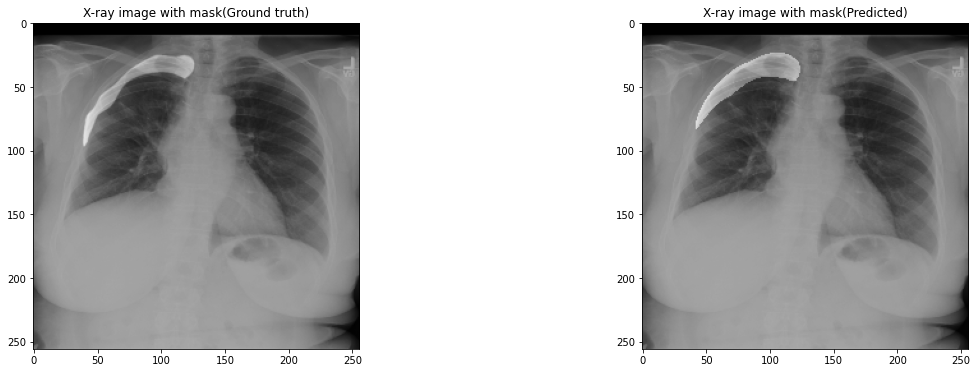

--- 0.8010809421539307 seconds ---


In [44]:
start_time = time.time()
final_fun_2(test_path[rand],test_encoded_pixel[rand])
print("--- %s seconds ---" % (time.time() - start_time))

# Showing output for wrongly classifed point for Function 2

In [30]:
#get index of wrongly classified point
bad_index=[]
for i in tqdm(range(0,len(test_path))):
  img = tf.io.read_file(test_path[i])
  image = tfio.image.decode_dicom_image(img, dtype=tf.uint8,color_dim=True,scale='preserve')
  image = tf.image.convert_image_dtype(image, tf.float32)#converting the image to tf.float32
  image=tf.squeeze(image,[0]) #squeezing the image because the file is of the shape(1,1024,1024,1) and we want (1024,1024,3)
  b = tf.constant([1,1,3], tf.int32)
  image=tf.tile(image,b)#the image is of the shape (1024,1024,1) to make it (1024,1024,3) I am using tf.tile
  image=tf.image.resize(image,size=[256,256])
  image=tf.expand_dims(image,axis=0)
  if test_encoded_pixel[i]==" -1" and model.predict(image)>=0.5:
    bad_index.append(i)
    

Ground truth of Classification is 0(Does not have Pneumothorax)
Ground truth of Segmentation -- There is no mask
****************************************************************************************************
Pneumothorax has been detected


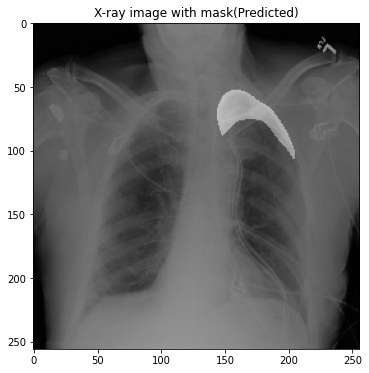

--- 0.4603886604309082 seconds ---


In [35]:
#pass point through the function 2 to get the wrong mask
#rand=random.randrange(0,len(test_path))
start_time = time.time()
final_fun_2(test_path[bad_index[rand]],test_encoded_pixel[bad_index[rand]])
print("--- %s seconds ---" % (time.time() - start_time))